<a href="https://colab.research.google.com/github/IrakizaGaius/activity-recognition-hmm/blob/main/Hmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install necessary Dependencies

In [1]:
!pip3 install hmmlearn

# Importing All the neccessary Dependencies

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.fft import rfft, rfftfreq
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from hmmlearn import hmm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


# Feature Extraction Configs

In [3]:
base_dir = 'Activity_Data'
activities = ['Jumping', 'Standing', 'Still', 'Walking']

TARGET_RATE = 50
WINDOW_SIZE = 300
STEP_SIZE = 15
SAMPLE_PERIOD = 1 / TARGET_RATE

# Feature Extraction & Data Sampling Functions

In [4]:
def estimate_sampling_rate(df):
    if 'seconds_elapsed' not in df.columns:
        raise ValueError("Missing 'seconds_elapsed' column in dataset.")
    diffs = np.diff(df['seconds_elapsed'])
    avg_period = np.mean(diffs)
    return 1.0 / avg_period if avg_period > 0 else TARGET_RATE

def resample_signal(df, target_rate=50):
    if 'seconds_elapsed' not in df.columns:
        raise ValueError("Missing 'seconds_elapsed' column for resampling.")

    t = df['seconds_elapsed'].values
    start, end = t.min(), t.max()
    target_period = 1.0 / target_rate
    new_time = np.arange(start, end, target_period)

    df_interp = pd.DataFrame({'seconds_elapsed': new_time})
    for axis in ['x', 'y', 'z']:
        df_interp[axis] = np.interp(new_time, t, df[axis])
    return df_interp

def extract_features(df, sensor_type, window_size=WINDOW_SIZE, step_size=STEP_SIZE):
    features = []
    num_windows = (len(df) - window_size) // step_size + 1
    for w in range(num_windows):
        start = w * step_size
        window = df.iloc[start:start + window_size]
        row = {}

        acc_x = window['x'].values
        acc_y = window['y'].values
        acc_z = window['z'].values

        for axis, signal in zip(['x','y','z'], [acc_x, acc_y, acc_z]):
            row[f'{sensor_type}_{axis}_rms'] = np.sqrt(np.mean(signal ** 2))
            row[f'{sensor_type}_{axis}_var'] = np.var(signal)
            row[f'{sensor_type}_{axis}_mean_abs'] = np.mean(np.abs(signal))

            fft_vals = np.abs(rfft(signal))
            fft_freqs = rfftfreq(window_size, d=SAMPLE_PERIOD)
            row[f'{sensor_type}_{axis}_dom_freq'] = fft_freqs[np.argmax(fft_vals)]

            row[f'{sensor_type}_{axis}_fft_energy'] = np.sum(fft_vals**2)
            low_freq_mask = fft_freqs < 5
            row[f'{sensor_type}_{axis}_lowfreq_energy'] = np.sum(fft_vals[low_freq_mask]**2)
            row[f'{sensor_type}_{axis}_fft_var'] = np.var(fft_vals)

        smv = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
        row[f'{sensor_type}_smv_rms'] = np.sqrt(np.mean(smv**2))
        row[f'{sensor_type}_smv_var'] = np.var(smv)
        row[f'{sensor_type}_smv_mean_abs'] = np.mean(np.abs(smv))

        features.append(row)

    return pd.DataFrame(features)

# Call Feature extraction & Data sampling Functions

In [5]:
all_features = []

for activity in activities:
    acc_path = os.path.join(base_dir, activity, f'{activity}_Accelerometer_combined.csv')
    gyro_path = os.path.join(base_dir, activity, f'{activity}_Gyroscope_combined.csv')

    acc_df = pd.read_csv(acc_path)
    gyro_df = pd.read_csv(gyro_path)

    acc_rate = estimate_sampling_rate(acc_df)
    gyro_rate = estimate_sampling_rate(gyro_df)

    acc_df = resample_signal(acc_df, target_rate=TARGET_RATE)
    gyro_df = resample_signal(gyro_df, target_rate=TARGET_RATE)

    acc_features = extract_features(acc_df, sensor_type='acc')
    gyro_features = extract_features(gyro_df, sensor_type='gyro')

    combined = pd.concat([acc_features.reset_index(drop=True),
                          gyro_features.reset_index(drop=True)], axis=1)
    combined['activity'] = activity
    all_features.append(combined)

features_all = pd.concat(all_features, ignore_index=True)


numeric_cols = features_all.drop(columns=['activity']).columns


scaler = StandardScaler()
features_all[numeric_cols] = scaler.fit_transform(features_all[numeric_cols])


# Data Splitting
train_df, temp_df = train_test_split(
    features_all,
    test_size=0.3,
    stratify=features_all['activity'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['activity'],
    random_state=42
)

# Save to CSV
train_path = os.path.join(base_dir, 'features_train_50Hz.csv')
val_path = os.path.join(base_dir, 'features_val_50Hz.csv')
test_path = os.path.join(base_dir, 'features_test_50Hz.csv')

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"Training set saved to: {train_path}  ({len(train_df)} samples)")
print(f"Validation set saved to: {val_path}  ({len(val_df)} samples)")
print(f"Test set saved to: {test_path}  ({len(test_df)} samples)")

Training set saved to: Activity_Data/features_train_50Hz.csv  (39 samples)
Validation set saved to: Activity_Data/features_val_50Hz.csv  (9 samples)
Test set saved to: Activity_Data/features_test_50Hz.csv  (9 samples)


# HMM Model structure and Training

Training samples: 39, Features: 48
PCA shape: (39, 10), Explained variance ratio: [8.73137816e-01 5.06373491e-02 3.46605264e-02 1.72611466e-02
 1.61426552e-02 6.05012876e-03 1.10055635e-03 4.51461599e-04
 2.45061512e-04 1.40042692e-04]

Training HMM...
✅ Training complete.
Predicted HMM states: [2 1 2 3 2 3 2 2 1 2 0 0 0 0 3 2 2 2 3 2 1 2 1 0 0 3 2 1 2 2 1 2 1 1 3 2 1
 3 1]

Transition Matrix:
 [[0.667 0.    0.    0.333]
 [0.111 0.111 0.556 0.222]
 [0.062 0.5   0.25  0.187]
 [0.    0.143 0.857 0.   ]]


         1     -60.16872620             +nan
         2      47.18469931    +107.35342551
         3      47.18469931      +0.00000000


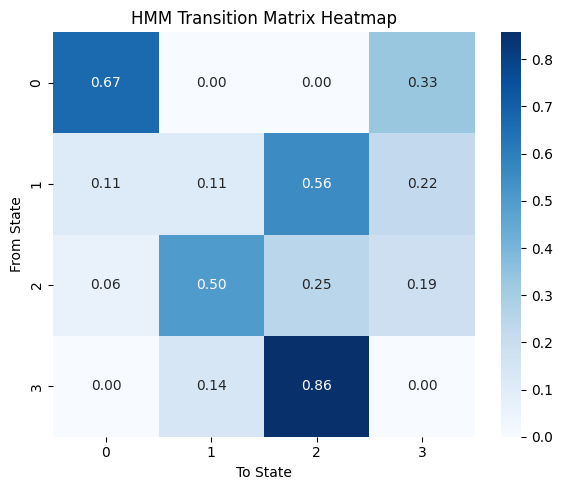

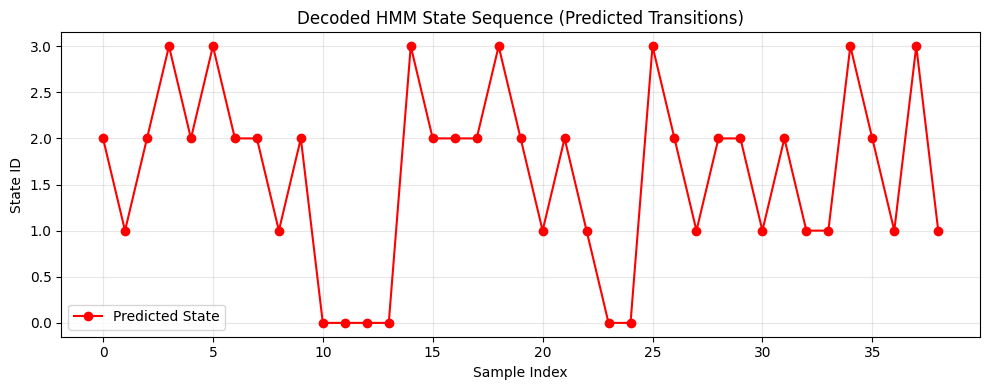

In [6]:
df = pd.read_csv("Activity_Data/features_train_50Hz.csv")
X = df.drop(columns=["activity"]).values
y = df["activity"].values

print(f"Training samples: {len(X)}, Features: {X.shape[1]}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
n_pca = 10
pca = PCA(n_components=n_pca, random_state=0)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA shape: {X_pca.shape}, Explained variance ratio: {pca.explained_variance_ratio_}")


n_components = 4
kmeans = KMeans(n_clusters=n_components, random_state=0, n_init=10).fit(X_pca)
init_means = kmeans.cluster_centers_

covars_init = np.zeros((n_components, X_pca.shape[1]))
for k in range(n_components):
    cluster_data = X_pca[kmeans.labels_ == k]
    if cluster_data.shape[0] == 0:
        covars_init[k] = np.var(X_pca, axis=0) + 1e-2
    else:
        covars_init[k] = np.var(cluster_data, axis=0) + 1e-2

# Build and fit Gaussian HMM
model = hmm.GaussianHMM(
    n_components=n_components,
    covariance_type="diag",
    n_iter=200,
    tol=1e-3,
    verbose=True,
    random_state=0
)

# Initialize parameters
model.init_params = "st"
model.params = "st"
model.means_ = init_means
model.covars_ = covars_init

print("\nTraining HMM...")
model.fit(X_pca)
print("✅ Training complete.")

# Prediction
states = model.predict(X_pca)
print("Predicted HMM states:", states)
print("\nTransition Matrix:\n", np.round(model.transmat_, 3))

# Visualization A: Transition matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(model.transmat_, annot=True, fmt=".2f", cmap="Blues")
plt.title("HMM Transition Matrix Heatmap")
plt.xlabel("To State")
plt.ylabel("From State")
plt.tight_layout()
plt.show()

# Visualization B: Decoded sequence transitions
plt.figure(figsize=(10, 4))
plt.plot(states, marker='o', linestyle='-', color='red', label='Predicted State')
plt.title("Decoded HMM State Sequence (Predicted Transitions)")
plt.xlabel("Sample Index")
plt.ylabel("State ID")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# HMM model evaluation & Visualization


Overall Accuracy: 0.89
Confusion Matrix:
 [[3 0 0 0]
 [0 3 0 0]
 [0 0 2 0]
 [0 0 1 0]]

Evaluation Table:
Activity       Samples   Sensitivity    Specificity    
Jumping        3         1.00           1.00           
Standing       3         1.00           1.00           
Still          2         1.00           0.86           
Walking        1         0.00           1.00           


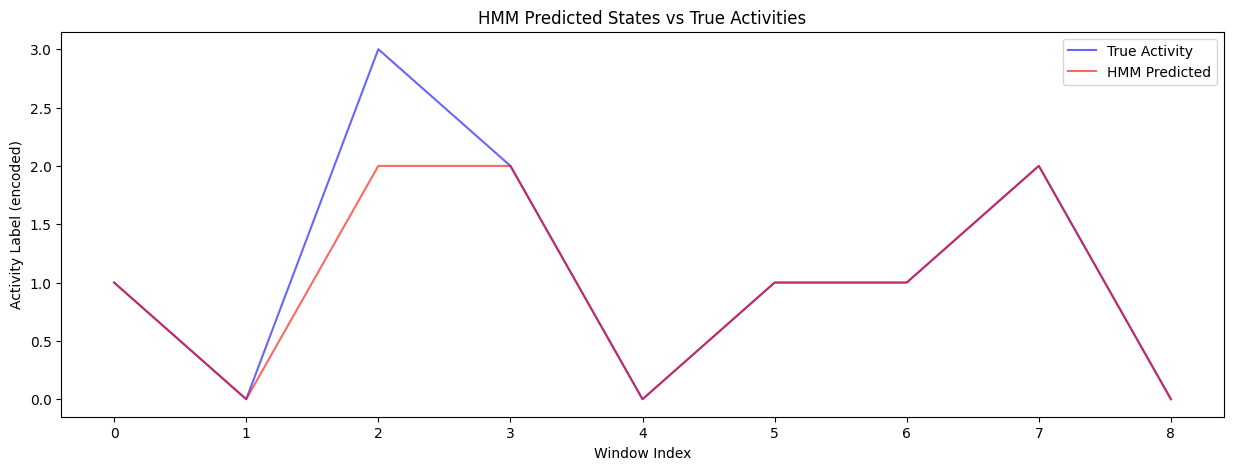

In [7]:
# Evalution on unseen test data
test_path = "Activity_Data/features_test_50Hz.csv"
df_test = pd.read_csv(test_path)
X_test = df_test.drop(columns=["activity"]).values
y_test = df_test["activity"].values

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)


states_test = model.predict(X_test_pca)

le = LabelEncoder()
y_encoded = le.fit_transform(y_test)
activities_encoded = np.arange(len(le.classes_))

state_to_label = {}
for s in range(n_components):
    labels_in_state = y_encoded[states_test == s]
    if len(labels_in_state) == 0:
        state_to_label[s] = -1
    else:
        state_to_label[s] = np.bincount(labels_in_state).argmax()

y_pred_encoded = np.array([state_to_label[s] for s in states_test])

# confusion matrix, accuracy, sensitivity, specificity

cm = confusion_matrix(y_encoded, y_pred_encoded, labels=activities_encoded)
acc = accuracy_score(y_encoded, y_pred_encoded)
print(f"\nOverall Accuracy: {acc:.2f}")
print("Confusion Matrix:\n", cm)

# Sensitivity & Specificity
sensitivity = np.diag(cm) / np.sum(cm, axis=1)
specificity = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    fp = cm[:,i].sum() - cm[i,i]
    specificity.append(tn / (tn + fp))

num_samples = cm.sum(axis=1)

# Print evaluation table
print("\nEvaluation Table:")
print(f"{'Activity':<15}{'Samples':<10}{'Sensitivity':<15}{'Specificity':<15}")
for i, act in enumerate(le.classes_):
    print(f"{act:<15}{num_samples[i]:<10}{sensitivity[i]:<15.2f}{specificity[i]:<15.2f}")

# Inverse transform to original labels for plotting
y_pred = le.inverse_transform(y_pred_encoded)
y_true = le.inverse_transform(y_encoded)

# Plot true vs predicted activities
plt.figure(figsize=(15,5))
plt.plot(y_encoded, label='True Activity', color='blue', alpha=0.6)
plt.plot(y_pred_encoded, label='HMM Predicted', color='red', alpha=0.6)
plt.xlabel('Window Index')
plt.ylabel('Activity Label (encoded)')
plt.title('HMM Predicted States vs True Activities')
plt.legend()
plt.show()


Validation Accuracy: 1.00
Validation Confusion Matrix:
 [[2 0 0 0]
 [0 3 0 0]
 [0 0 2 0]
 [0 0 0 2]]

Validation Evaluation Table:
Activity       Samples   Sensitivity    Specificity    
Jumping        2         1.00           1.00           
Standing       3         1.00           1.00           
Still          2         1.00           1.00           
Walking        2         1.00           1.00           

Mean Sensitivity (macro): 1.00
Mean Specificity (macro): 1.00


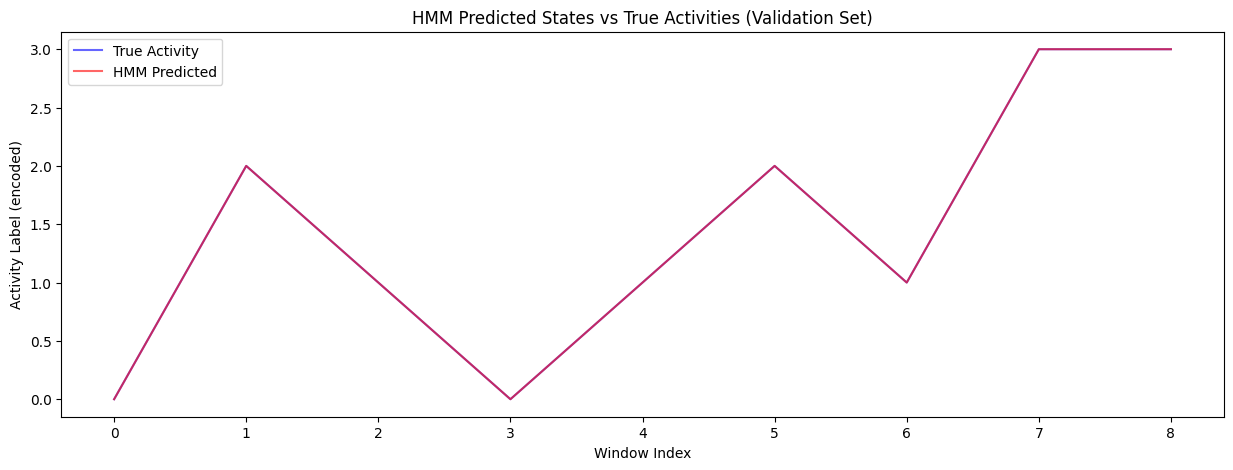

In [ ]:
# --------------------------
# Evaluation on Validation Data

val_path = "Activity_Data/features_val_50Hz.csv"
df_val = pd.read_csv(val_path)
# Fill NaNs only in numeric columns (leave 'activity' untouched)
numeric_cols = df_val.select_dtypes(include=[np.number]).columns
df_val[numeric_cols] = df_val[numeric_cols].fillna(df_val[numeric_cols].mean())
X_val = df_val.drop(columns=["activity"]).values
y_val = df_val["activity"].values

# Apply same scaling & PCA as training
X_val_scaled = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scaled)

# Predict hidden states using trained model
states_val = model.predict(X_val_pca)

# Map HMM states → activity labels (use same label encoder from training)
y_encoded_val = le.transform(y_val)
activities_encoded = np.arange(len(le.classes_))

state_to_label = {}
for s in range(n_components):
    labels_in_state = y_encoded_val[states_val == s]
    if len(labels_in_state) == 0:
        state_to_label[s] = -1
    else:
        state_to_label[s] = np.bincount(labels_in_state).argmax()

y_pred_val_encoded = np.array([state_to_label[s] for s in states_val])

# Confusion matrix & metrics
cm_val = confusion_matrix(y_encoded_val, y_pred_val_encoded, labels=activities_encoded)
acc_val = accuracy_score(y_encoded_val, y_pred_val_encoded)
print(f"\nValidation Accuracy: {acc_val:.2f}")
print("Validation Confusion Matrix:\n", cm_val)

# Sensitivity & Specificity
sensitivity_val = np.diag(cm_val) / np.maximum(np.sum(cm_val, axis=1), 1)
specificity_val = []
for i in range(len(cm_val)):
    tn = cm_val.sum() - (cm_val[i,:].sum() + cm_val[:,i].sum() - cm_val[i,i])
    fp = cm_val[:,i].sum() - cm_val[i,i]
    specificity_val.append(tn / (tn + fp))

num_samples_val = cm_val.sum(axis=1)

print("\nValidation Evaluation Table:")
print(f"{'Activity':<15}{'Samples':<10}{'Sensitivity':<15}{'Specificity':<15}")
for i, act in enumerate(le.classes_):
    print(f"{act:<15}{num_samples_val[i]:<10}{sensitivity_val[i]:<15.2f}{specificity_val[i]:<15.2f}")

# Mean stats
print(f"\nMean Sensitivity (macro): {np.nanmean(sensitivity_val):.2f}")
print(f"Mean Specificity (macro): {np.nanmean(specificity_val):.2f}")

# Visualization
plt.figure(figsize=(15,5))
plt.plot(y_encoded_val, label='True Activity', color='blue', alpha=0.6)
plt.plot(y_pred_val_encoded, label='HMM Predicted', color='red', alpha=0.6)
plt.xlabel('Window Index')
plt.ylabel('Activity Label (encoded)')
plt.title('HMM Predicted States vs True Activities (Validation Set)')
plt.legend()
plt.show()